<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/plot_sleep_staging_chambon2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep staging on the Sleep Physionet dataset using Chambon2018 network

This tutorial shows how to train and test a sleep staging neural network with
Braindecode. We adapt the time distributed approach of [1]_ to learn on
sequences of EEG windows using the openly accessible Sleep Physionet dataset
[2]_ [3]_.


In [3]:
!pip install braindecode
!pip install moabb

## Loading and preprocessing the dataset

### Loading

First, we load the data using the
:class:`braindecode.datasets.sleep_physionet.SleepPhysionet` class. We load
two recordings from two different individuals: we will use the first one to
train our network and the second one to evaluate performance (as in the `MNE`_
sleep staging example).





In [4]:
from numbers import Integral
from braindecode.datasets import SleepPhysionet

subject_ids = [0, 1]
dataset = SleepPhysionet(
    subject_ids=subject_ids, recording_ids=[2], crop_wake_mins=30)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 11.9GB/s]
100%|██████████████████████████████████████| 4.58k/4.58k [00:00<00:00, 777kB/s]
100%|█████████████████████████████████████| 52.0M/52.0M [00:00<00:00, 18.8GB/s]
100%|█████████████████████████████████████| 5.08k/5.08k [00:00<00:00, 3.69MB/s]

Download complete in 01m44s (98.8 MB)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Preprocessing

Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter. We omit the downsampling step of [1]_ as the Sleep
Physionet data is already sampled at a lower 100 Hz.



In [5]:
from braindecode.preprocessing import preprocess, Preprocessor
from numpy import multiply

high_cut_hz = 30
factor = 1e6

preprocessors = [
    Preprocessor(lambda data: multiply(data, factor), apply_on_array=True),  # Convert from V to uV
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz)
]


preprocess(dataset, preprocessors)

Reading 0 ... 3348000  =      0.000 ... 33480.000 secs...


/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Reading 0 ... 3447000  =      0.000 ... 34470.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



### Extract windows

We extract 30-s windows to be used in the classification task.



In [6]:
from braindecode.preprocessing import create_windows_from_events

mapping = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload=True,
    mapping=mapping
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### Window preprocessing

We also preprocess the windows by applying channel-wise z-score normalization
in each window.



In [7]:
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

### Split dataset into train and valid

We split the dataset into training and validation set taking
every other subject as train or valid.



In [8]:
split_ids = dict(train=subject_ids[::2], valid=subject_ids[1::2])
splits = windows_dataset.split(split_ids)
train_set, valid_set = splits["train"], splits["valid"]

## Create sequence samplers

Following the time distributed approach of [1]_, we need to provide our
neural network with sequences of windows, such that the embeddings of
multiple consecutive windows can be concatenated and provided to a final
classifier. We can achieve this by defining Sampler objects that return
sequences of window indices.
To simplify the example, we train the whole model end-to-end on sequences,
rather than using the two-step approach of [1]_ (i.e. training the feature
extractor on single windows, then freezing its weights and training the
classifier).




In [9]:
import numpy as np
from braindecode.samplers import SequenceSampler

n_windows = 3
n_windows_stride = 3

train_sampler = SequenceSampler(
    train_set.get_metadata(), n_windows, n_windows_stride, randomize=True
)
valid_sampler = SequenceSampler(valid_set.get_metadata(), n_windows, n_windows_stride)


print('Training examples: ', len(train_sampler))
print('Validation examples: ', len(valid_sampler))

Training examples:  372
Validation examples:  383


We also implement a transform to extract the label of the center window of a
sequence to use it as target.



In [10]:

def get_center_label(x):
    if isinstance(x, Integral):
        return x
    return x[np.ceil(len(x) / 2).astype(int)] if len(x) > 1 else x


train_set.target_transform = get_center_label
valid_set.target_transform = get_center_label

Finally, since some sleep stages appear a lot more often than others (e.g.
most of the night is spent in the N2 stage), the classes are imbalanced. To
avoid overfitting on the more frequent classes, we compute weights that we
will provide to the loss function when training.



In [11]:
from sklearn.utils import compute_class_weight

y_train = [train_set[idx][1] for idx in train_sampler]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Create model

We can now create the deep learning model. In this tutorial, we use the sleep
staging architecture introduced in [1]_, which is a four-layer convolutional
neural network. We use the time distributed version of the model, where the
feature vectors of a sequence of windows are concatenated and passed to a
linear layer for classification.




In [12]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018, TimeDistributed

cuda = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=31, cuda=cuda)

n_classes = 5
# Extract number of channels and time steps from dataset
n_channels, input_size_samples = train_set[0][0].shape

feat_extractor = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_outputs=n_classes,
    n_times=input_size_samples,
    return_feats=True
)

model = nn.Sequential(
    TimeDistributed(feat_extractor),  # apply model on each 30-s window
    nn.Sequential(  # apply linear layer on concatenated feature vectors
        nn.Flatten(start_dim=1),
        nn.Dropout(0.5),
        nn.Linear(feat_extractor.len_last_layer * n_windows, n_classes)
    )
)

# Send model to GPU
if cuda:
    model.cuda()

## Training

We can now train our network. :class:`braindecode.EEGClassifier` is a
braindecode object that is responsible for managing the training of neural
networks. It inherits from :class:`skorch.NeuralNetClassifier`, so the
training logic is the same as in
[Skorch](https://skorch.readthedocs.io/en/stable/)_.

<div class="alert alert-info"><h4>Note</h4><p>We use different hyperparameters from [1]_, as these hyperparameters were
   optimized on a different dataset (MASS SS3) and with a different number of
   recordings. Generally speaking, it is recommended to perform
   hyperparameter optimization if reusing this code on a different dataset or
   with more recordings.</p></div>




In [13]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 32
n_epochs = 10

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    classes=np.unique(y_train),
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss      dur
-------  ---------------  ------------  -----------  ---------------  ------------  -------
      1           0.2136        1.5768       0.0888           0.2000        1.6372  11.2625
      2           0.2036        1.4788       0.0888           0.2000        1.6676  9.0859
      3           0.2324        1.4033       0.1018           0.2236        1.6334  10.7264
      4           0.2923        1.3408       0.1149           0.2465        1.6790  4.4094
      5           0.3993        1.2123       0.4491           0.4004        1.6226  5.7789
      6           0.5286        1.0969       0.2742           0.4030        1.6132  4.4235
      7           0.5726        0.9675       0.6005           0.5699        1.3668  4.5055
      8           0.6251        0.8893       0.7076           0.5823        1.2966  5.7580
      9           0.6894        0.8148       0.7128           0.5793        1.3449  4.

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): TimeDistributed(
      (module): SleepStagerChambon2018(
        (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
        (feature_extractor): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
          (1): Identity()
          (2): ReLU()
          (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
          (5): Identity()
          (6): ReLU()
          (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
        )
      )
    )
    (1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=816, out_features=5, bias=True)
    )
  ),
)

## Plot results

We use the history stored by Skorch during training to plot the performance of
the model throughout training. Specifically, we plot the loss and the balanced
balanced accuracy for the training and validation sets.



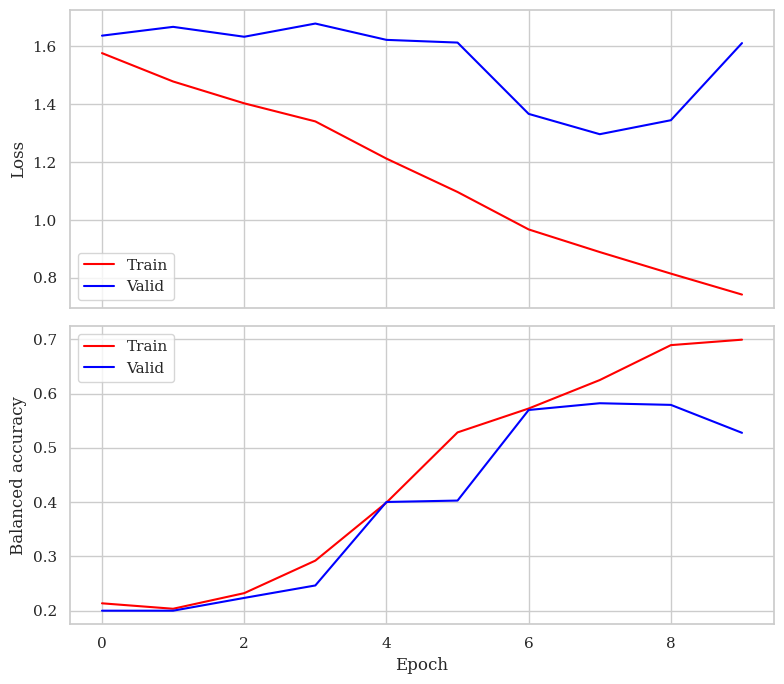

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())
df.index.name = "Epoch"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
df[['train_loss', 'valid_loss']].plot(color=['r', 'b'], ax=ax1)
df[['train_bal_acc', 'valid_bal_acc']].plot(color=['r', 'b'], ax=ax2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Balanced accuracy')
ax1.legend(['Train', 'Valid'])
ax2.legend(['Train', 'Valid'])
fig.tight_layout()
plt.show()

Finally, we also display the confusion matrix and classification report:




              precision    recall  f1-score   support

           0       0.14      0.33      0.20        61
           1       0.20      0.14      0.17        21
           2       0.56      0.34      0.42       194
           3       0.25      0.25      0.25        75
           4       0.06      0.06      0.06        32

    accuracy                           0.29       383
   macro avg       0.24      0.23      0.22       383
weighted avg       0.37      0.29      0.31       383



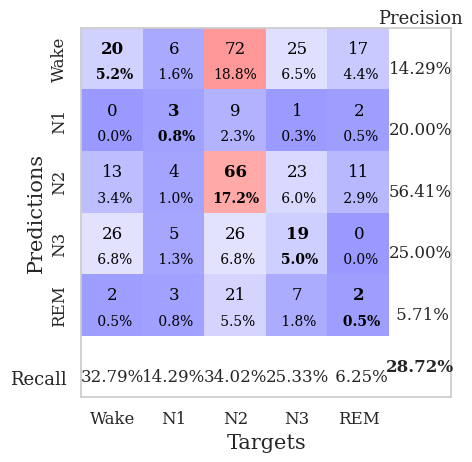

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
from braindecode.visualization import plot_confusion_matrix

y_true = [valid_set[[i]][1][0] for i in range(len(valid_sampler))]
y_pred = clf.predict(valid_set)

confusion_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(confusion_mat=confusion_mat,
                      class_names=['Wake', 'N1', 'N2', 'N3', 'REM'])

print(classification_report(y_true, y_pred))

Finally, we can also visualize the hypnogram of the recording we used for
validation, with the predicted sleep stages overlaid on top of the true
sleep stages. We can see that the model cannot correctly identify the
different sleep stages with this amount of training.



Text(0, 0.5, 'Sleep stage')

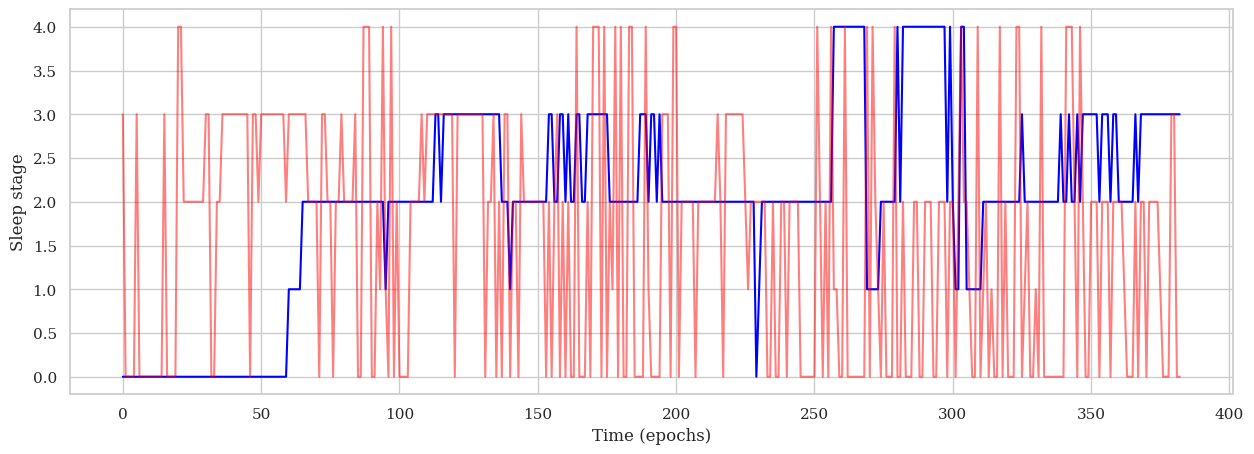

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_true, color='b', label='Expert annotations')
ax.plot(y_pred.flatten(), color='r', label='Predict annotations', alpha=0.5)
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Sleep stage')

Our model was able to learn despite the low amount of data that was available
(only two recordings in this example) and reached a balanced accuracy of
about 36% in a 5-class classification task (chance-level = 20%) on held-out
data.

<div class="alert alert-info"><h4>Note</h4><p>To further improve performance, more recordings should be included in the
   training set, and hyperparameters should be selected accordingly.
   Increasing the sequence length was also shown in [1]_ to help improve
   performance, especially when few EEG channels are available.</p></div>

